# Vocal separation

In [1]:
# Standard imports
import numpy as np
import librosa, librosa.display
import IPython.display as ipd
from IPython.display import Audio
import soundfile

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
plt.style.use('ggplot')

# Warning
import warnings
warnings.filterwarnings('ignore')

## Load an audio dataset

In [2]:
# Select audio
audio_data = '../xue_audio/Gre+w-o+vocal.m4a'

Audio(audio_data)

In [3]:
# Select audio
#audio_data = '../xue_audio/Gre+w-+vocal.m4a'

# Load audio
y, sr = librosa.load(audio_data, duration=120) # sr = default 22500

# Compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

## Plot a 5-second slice of the spectrum

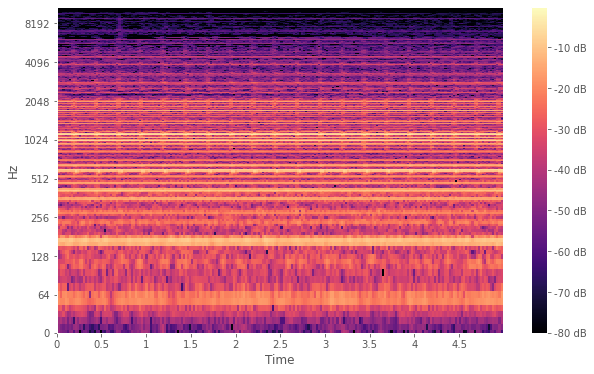

In [4]:
idx = slice(*librosa.time_to_frames([10, 15], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+02.0f dB')
plt.show()

The wiggly lines above are because of the vocal component. Our goal is to separate them from the accompanying instrumentation.

In [5]:
# Aggregate similar frames taking per-frequency median value
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

In [6]:
# Take pointwise minimium so that output of the filter isn't greater than the input
S_filter = np.minimum(S_full, S_filter)

# Calculate soft mask

In [7]:
# Use margin to reduce bleed between the vocals and instrumentation masks
margin_i, margin_v = 4, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

## Multiply masks with the input spectrum to separate components

In [8]:
# Separate the foreground, ie voice
S_foreground = mask_v * S_full

# Separate the background, ie noise
S_background = mask_i * S_full

## Plot the foreground and background of the audio

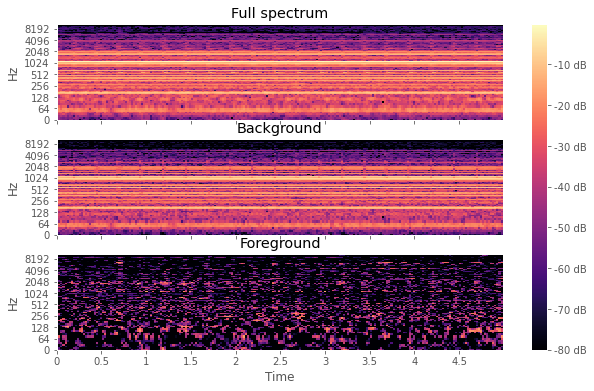

In [9]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax, format='%+02.0f dB')
plt.show()

# Take the inverse stft of the new spectrogram

In [10]:
# Inverse full audio
full_audio = librosa.istft(S_full)

# Inverse foreground audio
foreground_audio = librosa.istft(S_foreground)
print("full({}): {}".format(len(full_audio), full_audio))

# Save the clean audio
# soundfile.write('../orig.wav', y, sr) 
#soundfile.write('../xue_audio/full.wav', full_audio, sr) 
soundfile.write('../xue_audio/foreground.wav', foreground_audio, sr)

full(1091584): [0.0002282  0.00022437 0.00013965 ... 0.00279125 0.00273267 0.00266417]


# Play the audio

In [11]:
Audio('../xue_audio/foreground.wav')